# QSARtuna CLI Tutorial

step1,超参数优化：使用Optuna搜索最佳模型配置（only training set  
step2,模型构建：使用最佳配置构建模型并在测试集上评估（only training set  
step3,生产构建：在合并的训练和测试数据上重新训练最终模型（training + test  

### Create configuration

QSARtuna configuration can be read from a JSON file or created in Python. Here we create it in Python.

In [1]:
import sys
sys.path.append(".")

In [2]:
# Start with the imports.
import sklearn
import numpy
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import (
    OptimizationConfig,
    SVR,
    RandomForestRegressor,
    Ridge,
    Lasso,
    PLSRegression,
    KNeighborsRegressor
)
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts, PathFP, Avalon, JazzyDescriptors, PhyschemDescriptors

#### FOR REGRESSION：

In [72]:
# Prepare hyperparameter optimization configuration.
from optunaz.config.optconfig import ChemPropHyperoptRegressor
from optunaz.descriptors import SmilesBasedDescriptor, SmilesFromFile
config = OptimizationConfig(
    data=Dataset(
        input_column="smiles (Canonical)",  # Typical names are "SMILES" and "smiles".
        response_column="DG(MLE) (kcal/mol)",  # Often a specific name (like here), or just "activity".
        training_dataset_file="./train.csv",
        test_dataset_file="./test.csv"  # Hidden during optimization.
    ),
    descriptors=[
        SmilesFromFile.new(),
    ],
    algorithms=[
        ChemPropHyperoptRegressor.new( #Hyperopt自动优化参数
            epochs=200, #训练几个batch，1个batch中，通过设置batch size控制多少次迭代遍历所有样本;三个值在n_trials里优化
            ensemble_size=5, #控制创建多少个具有不同权重初始化的模型
            num_iters=50, #参数优化次数
            #features_generator=["rdkit_2d", "rdkit_2d_normalized", "morgan", "morgan_count"], #生成额外特征
            features_generator=["rdkit_2d"],
            search_parameter_level=["auto"] #自动优化级别，6包含batch_size优化 
        )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=5,
        n_trials=2,  # Total number of trials.
        n_startup_trials=1,  # Number of startup ("random") trials.
        random_seed=42, # Seed for reproducability
        n_chemprop_trials=1, # run one enqueued chemprop trial and 1 undirected trial
        split_chemprop=False, # this is set to true by default (shown here for illustration)
        direction=OptimizationDirection.MAXIMIZATION,
    ),
) 

#### FOR CLASSIFICATION：

In [6]:
from optunaz.config.optconfig import ChemPropHyperoptClassifier, ChemPropClassifier, RandomForestClassifier, CalibratedClassifierCVWithVA, SVC, LogisticRegression, KNeighborsClassifier
from optunaz.descriptors import SmilesBasedDescriptor, SmilesFromFile

config = OptimizationConfig(
    data=Dataset(
        input_column="smiles (Canonical)",  # Typical names are "SMILES" and "smiles".
        response_column="DG(MLE) (kcal/mol)",  # Often a specific name (like here), or just "activity".
        training_dataset_file="./train.csv",
        test_dataset_file="./test.csv"  # Hidden during optimization.
    ),
    descriptors=[
        SmilesFromFile.new(),
#        ECFP.new(),
#        ECFP_counts.new(),
#        MACCS_keys.new(),
#        PathFP.new(),
#        Avalon.new(),
#        JazzyDescriptors.new(), 
#        PhyschemDescriptors.new()
    ],
    algorithms=[
        ChemPropHyperoptClassifier.new( #Hyperopt自动优化参数
            epochs=20, #训练几个batch，1个batch中，通过设置batch size控制多少次迭代遍历所有样本
            ensemble_size=5, #控制创建多少个具有不同权重初始化的模型
            num_iters=50, #参数优化次数
            features_generator=["rdkit_2d", "rdkit_2d_normalized", "morgan", "morgan_count"], #生成额外特征
            search_parameter_level=["auto"] #自动优化级别，6包含batch_size优化 
        )
#        RandomForestClassifier.new(n_estimators={"low": 100, "high": 200}),
#        CalibratedClassifierCVWithVA.new(
#            estimator=RandomForestClassifier.new(
#                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
#                    low=100, high=200
#                )
#            ),
#            n_folds=5,
#            ensemble="True",
#            method="sigmoid", 
#        ),
#        SVC.new(), 
#        LogisticRegression.new(), 
#        KNeighborsClassifier.new()
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=10, #1为禁用交叉验证，5平衡，10慢/小数据使用
        n_trials=20, # run only one random forest classifier trial
        n_startup_trials=10,
        n_chemprop_trials=5, # run one enqueued chemprop trial and 1 undirected trial
        split_chemprop=True, # this is set to true by default (shown here for illustration)
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

### Run optimization

In [73]:
# Setup basic logging.
import logging
from importlib import reload
reload(logging)
logging.basicConfig(level=logging.INFO)
logging.getLogger("train").disabled = False # Prevent ChemProp from logging
import numpy as np
np.seterr(divide="ignore")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import tqdm
from functools import partialmethod, partial
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # Prevent tqdm in ChemProp from flooding log

# Avoid decpreciated warnings from packages etc
import warnings
warnings.simplefilter("ignore")
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [74]:
# Run Optuna Study.
study = optimize(config, study_name="my_study")
# Optuna will log it's progress to sys.stderr
# (usually rendered in red in Jupyter Notebooks).

[I 2025-11-25 12:37:04,321] A new study created in memory with name: my_study
INFO:train:Fold 0
INFO:train:Model 0 best validation rmse = 3.345834 on epoch 3
INFO:train:Model 0 test rmse = 3.692394
INFO:train:Ensemble test rmse = 3.692394
INFO:train:1-fold cross validation
INFO:train:	Seed 0 ==> test rmse = 3.692394
INFO:train:Overall test rmse = 3.692394 +/- 0.000000
INFO:train:Elapsed time = 0:00:03
INFO:train:Fold 0
INFO:train:Model 0 best validation rmse = 2.231287 on epoch 5
INFO:train:Model 0 test rmse = 1.908635
INFO:train:Ensemble test rmse = 1.908635
INFO:train:1-fold cross validation
INFO:train:	Seed 0 ==> test rmse = 1.908635
INFO:train:Overall test rmse = 1.908635 +/- 0.000000
INFO:train:Elapsed time = 0:00:03
INFO:train:Fold 0
INFO:train:Model 0 best validation rmse = 2.234982 on epoch 0
INFO:train:Model 0 test rmse = 4.258718
INFO:train:Ensemble test rmse = 4.258718
INFO:train:1-fold cross validation
INFO:train:	Seed 0 ==> test rmse = 4.258718
INFO:train:Overall test rmse

Duplicated trial: {'algorithm_name': 'ChemPropHyperoptRegressor', 'ChemPropHyperoptRegressor_algorithm_hash': 'dac43730034166fbb28986f09c71b2cf', 'ensemble_size__dac43730034166fbb28986f09c71b2cf': 5, 'epochs__dac43730034166fbb28986f09c71b2cf': 50, 'features_generator__dac43730034166fbb28986f09c71b2cf': <ChemPropFeatures_Generator.RDKIT_2D: 'rdkit_2d'>, 'num_iters__dac43730034166fbb28986f09c71b2cf': 20, 'search_parameter_level__dac43730034166fbb28986f09c71b2cf': <ChemPropSearch_Parameter_Level.AUTO: 'auto'>, 'descriptor': '{"name": "SmilesFromFile", "parameters": {}}'}, return [-3.453414229570857]


### Visualize optimization progress

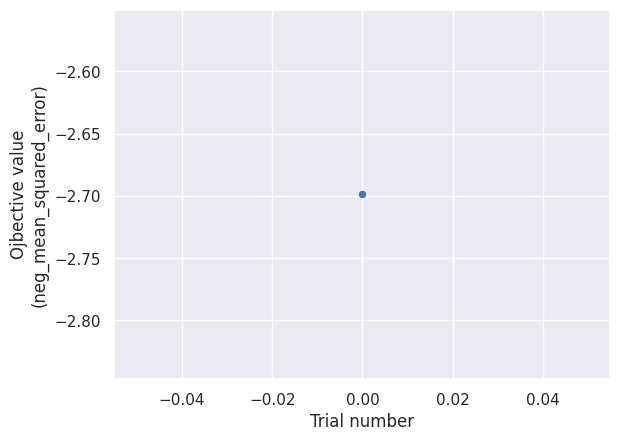

In [66]:
import seaborn as sns
sns.set_theme(style="darkgrid")
default_reg_scoring= config.settings.scoring
ax = sns.scatterplot(data=study.trials_dataframe(), x="number", y="value");
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

Sometimes it might be interesting to look at individual CV scores instead of aggregated score (mean CV score by default). Here we can plot all 3 cross validation scores (neg_mean_squared_error) for each trial (folds highlighted using different colors).

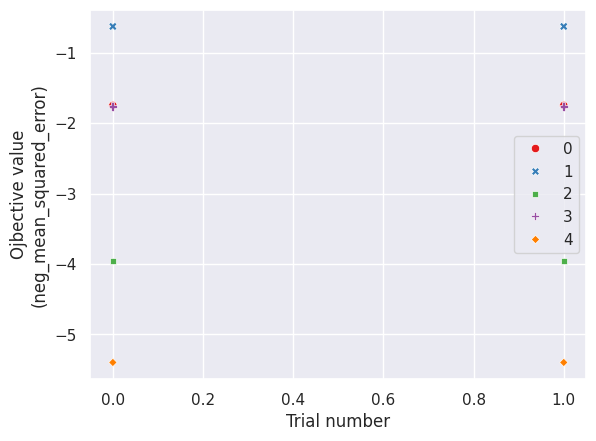

In [67]:
cv_test = study.trials_dataframe()["user_attrs_test_scores"].map(lambda d: d[default_reg_scoring])
x = []
y = []
fold = []
for i, vs in cv_test.items():
    for idx, v in enumerate(vs):
        x.append(i)
        y.append(v)
        fold.append(idx)
ax = sns.scatterplot(x=x, y=y, hue=fold, style=fold, palette='Set1')
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

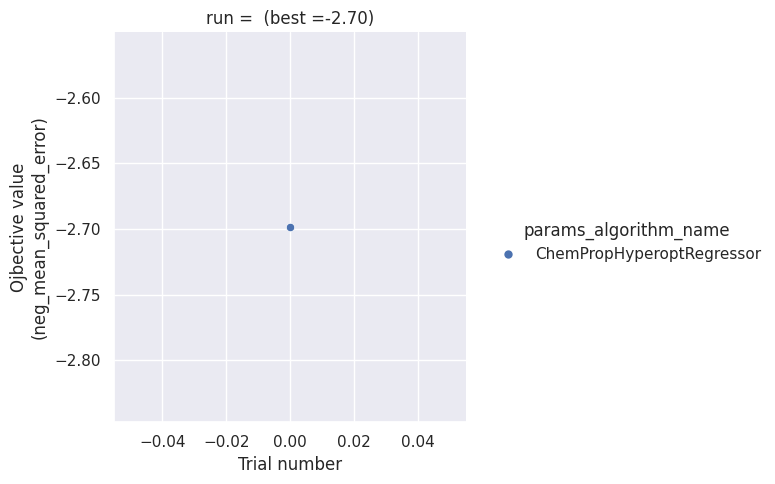

In [68]:
import seaborn as sns

comparison = study.trials_dataframe().assign(run=f' (best ={study.best_value:.2f})')

default_reg_scoring= config.settings.scoring
ax = sns.relplot(data=comparison, x="number", y="value", 
                 col='run',hue='params_algorithm_name', 
                 facet_kws={"sharey":False})
ax.set(xlabel="Trial number",ylabel=f"Ojbective value\n({default_reg_scoring})")
ax.tight_layout()

### Pick the best trial and build a model for it

We pick the best trial, inspect its configuration, build the best model, and save it as a pickled file.

In [69]:
# Get the best Trial from the Study and make a Build (Training) configuration for it.
buildconfig = buildconfig_best(study)

Optional: write out JSON of the best configuration.

In [70]:
import apischema
buildconfig_as_dict = apischema.serialize(buildconfig)

import json
print(json.dumps(buildconfig_as_dict, indent=2))

with open("best_buildconfig.json", 'w') as f:
    json.dump(buildconfig_as_dict, f, indent=2)

{
  "data": {
    "training_dataset_file": "./train.csv",
    "input_column": "smiles (Canonical)",
    "response_column": "DG(MLE) (kcal/mol)",
    "response_type": "regression",
    "deduplication_strategy": {
      "name": "KeepMedian"
    },
    "split_strategy": {
      "name": "NoSplitting"
    },
    "test_dataset_file": "./test.csv",
    "save_intermediate_files": false,
    "log_transform": false,
    "log_transform_base": null,
    "log_transform_negative": null,
    "log_transform_unit_conversion": null,
    "probabilistic_threshold_representation": false,
    "probabilistic_threshold_representation_threshold": null,
    "probabilistic_threshold_representation_std": null
  },
  "metadata": {
    "name": "",
    "cross_validation": 5,
    "shuffle": false,
    "best_trial": 0,
    "best_value": -2.6987673149341154,
    "n_trials": 2,
    "visualization": null
  },
  "descriptor": {
    "name": "SmilesFromFile",
    "parameters": {}
  },
  "settings": {
    "mode": "regression

Build (re-Train) and save the best model. This time training uses all training data, without splitting it into cross-validation folds.

In [75]:
best_build = build_best(buildconfig, "./best.pkl")

INFO:train:Fold 0
INFO:train:Model 0 best validation rmse = 0.601284 on epoch 27
INFO:train:Model 0 test rmse = 1.989907
INFO:train:Ensemble test rmse = 1.989907
INFO:train:1-fold cross validation
INFO:train:	Seed 0 ==> test rmse = 1.989907
INFO:train:Overall test rmse = 1.989907 +/- 0.000000
INFO:train:Elapsed time = 0:00:13
INFO:train:Fold 0
INFO:train:Model 0 best validation rmse = 1.044385 on epoch 0
INFO:train:Model 0 test rmse = 1.720854
INFO:train:Ensemble test rmse = 1.720854
INFO:train:1-fold cross validation
INFO:train:	Seed 0 ==> test rmse = 1.720854
INFO:train:Overall test rmse = 1.720854 +/- 0.000000
INFO:train:Elapsed time = 0:00:09
INFO:train:Fold 0
INFO:train:Model 0 best validation rmse = 0.736280 on epoch 34
INFO:train:Model 0 test rmse = 1.611483
INFO:train:Ensemble test rmse = 1.611483
INFO:train:1-fold cross validation
INFO:train:	Seed 0 ==> test rmse = 1.611483
INFO:train:Overall test rmse = 1.611483 +/- 0.000000
INFO:train:Elapsed time = 0:00:13
INFO:train:Fold 0

Now we can explore how good the best model performs on the test (holdout) set.

In [76]:
import pickle
with open("./best.pkl", "rb") as f:
    model_best = pickle.load(f)
model_best.predict_from_smiles(["NC1=NC=CC=C1C2=NC3=CC=C(C4=C(F)C(N5CC6(CN(C(C)=O)C6)C5)=CC=C4)N=C3N2C7=CC=C(C8(CCC8)N)C=C7", "CC(=O)Nc1ccc(O)cc1"])

array([1.8531138e+14, 1.8531138e+14])

In [77]:
import pandas as pd

df_best = pd.read_csv(config.data.test_dataset_file)  # Load test data. (OR training_dataset_file, if you want to look)

expected_best = df_best[config.data.response_column]
predicted_best = model_best.predict_from_smiles(df_best[config.data.input_column])
#model_best.predict_from_smiles(df_best[config.data.input_column], explain=True) #explain

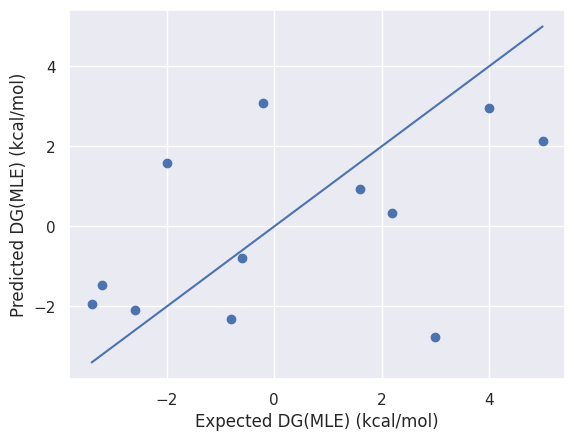

In [78]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
plt.clf()
ax = plt.scatter(expected_best, predicted_best)
lims = [expected_best.min(), expected_best.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

We can also calculate custom metrics for the best model:

In [79]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected_best, y_pred=predicted_best)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected_best, y_pred=predicted_best))  

# MAE
mae = mean_absolute_error(y_true=expected_best, y_pred=predicted_best)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.138137305895093, RMSE: 2.5459626231703902, Mean absolute error: 2.04087176322937


If the metrics look acceptable, the model is ready for use.

In [20]:
# FOR CLASSIFICATION
from sklearn.metrics import (roc_auc_score)
import numpy as np

roc_auc = roc_auc_score(y_true=expected_best, y_score=predicted_best)   
print(f"RMSE: {roc_auc}")

RMSE: 0.7476923076923077


### Build merged model

if here is more data available in testset:

In [ ]:
# 1. 加载之前保存的buildconfig  
with open("best_buildconfig.json", "r") as f:  
    buildconfig = deserialize(BuildConfig, json.load(f))  
# 2. 修改数据集路径  
buildconfig.data.test_dataset_file = "new_combined_dataset.csv"  

Now we can merge train and test data, and build (train) the model again. We will have no more holdout data to evaluate the model, but hopefully the model will be a little better by seeing a little more data.

In [80]:
# Build (Train) and save the model on the merged train+test data.
build_merged(buildconfig, "./merged.pkl")

INFO:train:Fold 0
INFO:train:Model 0 best validation rmse = 1.068464 on epoch 20
INFO:train:Model 0 test rmse = 1.594431
INFO:train:Ensemble test rmse = 1.594431
INFO:train:1-fold cross validation
INFO:train:	Seed 0 ==> test rmse = 1.594431
INFO:train:Overall test rmse = 1.594431 +/- 0.000000
INFO:train:Elapsed time = 0:00:16
INFO:train:Fold 0
INFO:train:Model 0 best validation rmse = 1.362357 on epoch 0
INFO:train:Model 0 test rmse = 2.784570
INFO:train:Ensemble test rmse = 2.784570
INFO:train:1-fold cross validation
INFO:train:	Seed 0 ==> test rmse = 2.784570
INFO:train:Overall test rmse = 2.784570 +/- 0.000000
INFO:train:Elapsed time = 0:00:12
INFO:train:Fold 0
INFO:train:Model 0 best validation rmse = 1.149533 on epoch 20
INFO:train:Model 0 test rmse = 2.154765
INFO:train:Ensemble test rmse = 2.154765
INFO:train:1-fold cross validation
INFO:train:	Seed 0 ==> test rmse = 2.154765
INFO:train:Overall test rmse = 2.154765 +/- 0.000000
INFO:train:Elapsed time = 0:00:16
INFO:train:Fold 0

In [81]:
import pickle
with open("./merged.pkl", "rb") as f:
    model_merged = pickle.load(f)
model_merged.predict_from_smiles(["NC1=NC=CC=C1C2=NC3=CC=C(C4=C(F)C(N5CC6(CN(C(C)=O)C6)C5)=CC=C4)N=C3N2C7=CC=C(C8(CCC8)N)C=C7", "CC(=O)Nc1ccc(O)cc1"])

array([3.71311709e+13, 3.71311709e+13])

In [82]:
import pandas as pd

df_merged = pd.read_csv(config.data.test_dataset_file)  # Load test data. (OR training_dataset_file, if you want to look)

expected_merged = df_merged[config.data.response_column]
predicted_merged = model_merged.predict_from_smiles(df_merged[config.data.input_column])
#model_merged.predict_from_smiles(df_merged[config.data.input_column], explain=True) #explain

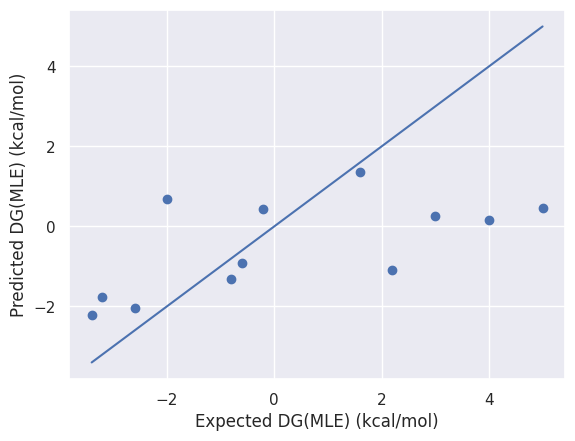

In [83]:
# Plot expected vs predicted values for the merged model.
import matplotlib.pyplot as plt
plt.clf()
ax = plt.scatter(expected_merged, predicted_merged)
lims = [expected_merged.min(), expected_merged.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

In [84]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected_merged, y_pred=predicted_merged)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected_merged, y_pred=predicted_merged))  

# MAE
mae = mean_absolute_error(y_true=expected_merged, y_pred=predicted_merged)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.2743168900844555, RMSE: 2.3361810123553837, Mean absolute error: 1.8318936616182324


In [26]:
# FOR CLASSIFICATION
from sklearn.metrics import (roc_auc_score)
import numpy as np

roc_auc = roc_auc_score(y_true=expected_merged, y_score=predicted_merged)   
print(f"RMSE: {roc_auc}")

RMSE: 0.9815384615384615


### USE MODLE

In [85]:
from rdkit import Chem
work_list = ['NC1=NC=CC=C1C(N=C2N3N=C(C4=CC=CC=C4)C=C2)=C3C5=CC=C(CN6CCC(NC7=CC=NC(C#N)=N7)CC6)C=C5',
'NC1=NC=CC=C1C(N=C2N3N=C(C4=CC=CC=C4)C=C2)=C3C5=CC=C(CNCCC(C=C6O)=CC=C6C=O)C=C5',
'NC1=NC=CC=C1C2=NN(C=CC(C3=CC=CC=C3)=N4)C4=C2C5=CC=C(CN6CCC(NC7=CC=NC(C#N)=N7)CC6)C=C5',
'NC1=NC=CC=C1C2=NN(C=CC(C3=CC=CC=C3)=N4)C4=C2C5=CC=C(CNCCC(C=C6O)=CC=C6C=O)C=C5']
mol_list = [Chem.MolFromSmiles(smi) for smi in work_list]
result_list = []
for mol in mol_list:
    result_list.append(Chem.MolToSmiles(mol, canonical=True))
print(result_list)

['N#Cc1nccc(NC2CCN(Cc3ccc(-c4c(-c5cccnc5N)nc5ccc(-c6ccccc6)nn45)cc3)CC2)n1', 'Nc1ncccc1-c1nc2ccc(-c3ccccc3)nn2c1-c1ccc(CNCCc2ccc(C=O)c(O)c2)cc1', 'N#Cc1nccc(NC2CCN(Cc3ccc(-c4c(-c5cccnc5N)nn5ccc(-c6ccccc6)nc45)cc3)CC2)n1', 'Nc1ncccc1-c1nn2ccc(-c3ccccc3)nc2c1-c1ccc(CNCCc2ccc(C=O)c(O)c2)cc1']


In [86]:
import pickle
with open("./merged.pkl", "rb") as f:
    model = pickle.load(f)
model.predict_from_smiles(result_list)

array([-8.52638602e-01,  3.71311709e+13, -7.04750180e-01,  3.71311709e+13])

In [88]:
df = pd.read_csv('product.csv')  # Load data.

predicted = model.predict_from_smiles(df['smiles (Canonical)'])
print(predicted)

[ 3.71311709e+13  3.71311709e+13  3.71311709e+13  3.71311709e+13
  3.71311709e+13  3.71311709e+13  3.71311709e+13  3.71311709e+13
  3.71311709e+13  3.71311709e+13  3.71311709e+13  3.71311709e+13
  3.71311709e+13  3.71311709e+13  3.71311709e+13  3.71311709e+13
  3.71311709e+13  3.71311709e+13  3.71311709e+13  3.71311709e+13
  3.71311709e+13  3.71311709e+13  3.71311709e+13  3.71311709e+13
  3.71311709e+13  3.71311709e+13  3.71311709e+13  3.54551047e-01
 -1.69600892e+00  2.29628421e-02 -1.28545308e+00 -7.23578453e-01
 -7.29615867e-01 -1.67441055e-01  3.04174811e-01 -1.36560583e+00
 -1.13482392e+00 -1.13412693e-01 -1.37914741e+00  5.89270532e-01
 -1.04889810e+00  2.37745523e-01 -8.48336339e-01 -1.21168971e+00
  3.96845311e-01 -1.34275460e+00  7.82942325e-02 -9.95687962e-01
 -1.61162579e+00  1.46177101e+00  9.59302902e-01 -2.54997945e+00
  1.02577567e+00  6.81939423e-02  5.23847818e-01  4.67425376e-01
  4.86212939e-01 -1.28154814e+00  4.50784028e-01  1.07271373e+00
  3.26472789e-01  3.48078

In [89]:
df['qsar-dGfep-AKTe17k'] = predicted

In [90]:
df.to_csv('product.csv', index=False)